In this notebook, we experiment with the idea of a broader network, instead of a deeper one. We use only one convolutional layer, but with an increasing number of kernels.
 * We first train 8 independent versions of AnalogNet M1, ..., M8, each with k kernels, with k in (1-8), and report their testing accuracy (after regularisation, binarisation, weight rounding, FC retraining...).
 * We then additively train 8 networks N1, ..., N8, each with k kernels (k in (1-8)). The network N(i+1) re-uses the i kernels of Ni, and is only differentirated with one newly trained kernel. This is done to eventually implement only N8 on the SCAMP5 vision system, but by troncating the output vector of the convolutional part, we should get the same effect as a Mj, without having to do 8 captures.


Independently trained networks:
 * 1 kernel: 89.28% final testing accuracy (88.87% after first phase)
 * 2 kernels: 95.13% final testing accuracy (95.65% after first phase)
 * 3 kernels (similar to AnalogNetv2): 96.92% final testing accuracy (96.68% after first phase)
 * 4 kernels: 97.19% final testing accuracy (97.02% after first phase)
 * 5 kernels: 97.47% final testing accuracy (97.00% after first phase)
 * 6 kernels: 98.17% final testing accuracy (98.01% after first phase)
 * 7 kernels: 98.26% final testing accuracy (97.85% after first phase)
 

In [0]:
!nvidia-smi

In [0]:
EPOCHS = 50
BATCH_SIZE = 100
LR = 0.001

ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.
REG_CONSTANT = 4.

MAX_BIN_RATE = 10

BATCH_SIZE_FC = 50
LR_FC = 0.0001
EPOCHS_FC = 100

# 0 Import data and utils

In [0]:
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Simulate an input binarization
x_train = np.minimum(x_train, 100) // 100 * 120
x_test = np.minimum(x_test, 100) // 100 * 120

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
y_train.shape

(60000,)

In [0]:
# Sigmoids, whose steepness and bias can be adjusted
# A very steep sigmoid (high bin_rate) simulates a binarization
MAX_BIN_RATE = 50
def binarize_tensor_differentiable(input, thresh, bin_rate):
  """
  out1 = tf.nn.sigmoid(bin_rate*(input[...,:1] - thresh[0]))
  out2 = tf.nn.sigmoid(bin_rate*(input[...,1:2] - thresh[1]))
  out3 = tf.nn.sigmoid(bin_rate*(input[...,2:3] - thresh[2]))
  return tf.concat([out1, out2, out3], axis=-1)
  """
  return tf.nn.sigmoid(bin_rate*(input - thresh))

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1)
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))
  
  return accs.mean()

In [0]:
def test_accuracy_bin_rate_fc(bin_rate_feed, verbose=False):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE_FC)
  for i in range(x_test.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    
    xs = np.expand_dims(x_test[start:stop],-1)
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  if verbose:
    print('Testing Acc.: {}'.format(
          accs.mean()))
  return accs.mean()

In [0]:
def custom_pooling(conv_bin):
  sum1 = tf.reduce_sum(conv_bin[:,5:14,0:9,:], axis=[1,2])
  sum2 = tf.reduce_sum(conv_bin[:,14:23,0:9,:], axis=[1,2])
  sum3 = tf.reduce_sum(conv_bin[:,0:9,5:14,:], axis=[1,2])
  sum4 = tf.reduce_sum(conv_bin[:,5:14,5:14,:], axis=[1,2])
  sum5 = tf.reduce_sum(conv_bin[:,14:23,5:14,:], axis=[1,2])
  sum6 = tf.reduce_sum(conv_bin[:,19:28,5:14,:], axis=[1,2])
  sum7 = tf.reduce_sum(conv_bin[:,0:9,14:23,:], axis=[1,2])
  sum8 = tf.reduce_sum(conv_bin[:,5:14,14:23,:], axis=[1,2])
  sum9 = tf.reduce_sum(conv_bin[:,14:23,14:23,:], axis=[1,2])
  sum10 = tf.reduce_sum(conv_bin[:,19:28,14:23,:], axis=[1,2])
  sum11 = tf.reduce_sum(conv_bin[:,5:14,19:28,:], axis=[1,2])
  sum12 = tf.reduce_sum(conv_bin[:,14:23,19:28,:], axis=[1,2])
  
  pool = tf.concat([sum1, sum2, sum3, sum4, sum5, sum6, 
                       sum7, sum8, sum9, sum10, sum11, sum12], axis=1)
  
  return pool

# 1 Independently trained networks

In [0]:
WIDTH = 3

## 1.1 Network definition

In [0]:
# Define the network
def net1(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv = slim.conv2d(input, WIDTH, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

## 1.2 Training

In [0]:
"""
# Reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
"""

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 2.535214254359404
Testing Acc.: 0.6161999973654747
Epoch 2 completed, average training loss is 1.014912471473217
Testing Acc.: 0.7217999994754791
Epoch 3 completed, average training loss is 0.7587293477356434
Testing Acc.: 0.7972000002861023
Epoch 4 completed, average training loss is 0.626639928072691
Testing Acc.: 0.8217999970912934
Epoch 5 completed, average training loss is 0.5453105934957663
Testing Acc.: 0.8418000000715256
Epoch 6 completed, average training loss is 0.4900413893163204
Testing Acc.: 0.8735999995470047
Epoch 7 completed, average training loss is 0.450334737226367
Testing Acc.: 0.8795999974012375
Epoch 8 completed, average training loss is 0.4043542609612147
Testing Acc.: 0.897700001001358
Epoch 9 completed, average training loss is 0.36059076855580013
Testing Acc.: 0.8867000007629394
Epoch 10 completed, average training loss is 0.3366258120536804
Testing Acc.: 0.9010000026226044
Epoch 11 completed, average training loss i

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9668000048398971


In [0]:
# Save models, for not having to fully retrain it each time.

saver = tf.train.Saver()
saver.save(sess, '1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

'1_layer_3_kernels_bin_reg/model.ckpt'

In [0]:
#!zip -r 1_layer_1_kernels_bin_reg.zip 1_layer_1_kernels_bin_reg
!zip -r 1_layer_2_kernels_bin_reg.zip 1_layer_2_kernels_bin_reg
!zip -r 1_layer_3_kernels_bin_reg.zip 1_layer_3_kernels_bin_reg
!zip -r 1_layer_4_kernels_bin_reg.zip 1_layer_4_kernels_bin_reg
!zip -r 1_layer_5_kernels_bin_reg.zip 1_layer_5_kernels_bin_reg
!zip -r 1_layer_6_kernels_bin_reg.zip 1_layer_6_kernels_bin_reg
!zip -r 1_layer_7_kernels_bin_reg.zip 1_layer_7_kernels_bin_reg
!zip -r 1_layer_8_kernels_bin_reg.zip 1_layer_8_kernels_bin_reg

updating: 1_layer_2_kernels_bin_reg/ (stored 0%)
updating: 1_layer_2_kernels_bin_reg/model.ckpt.index (deflated 40%)
updating: 1_layer_2_kernels_bin_reg/checkpoint (deflated 42%)
updating: 1_layer_2_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 28%)
updating: 1_layer_2_kernels_bin_reg/model.ckpt.meta (deflated 88%)
  adding: 1_layer_3_kernels_bin_reg/ (stored 0%)
  adding: 1_layer_3_kernels_bin_reg/model.ckpt.index (deflated 40%)
  adding: 1_layer_3_kernels_bin_reg/checkpoint (deflated 42%)
  adding: 1_layer_3_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 29%)
  adding: 1_layer_3_kernels_bin_reg/model.ckpt.meta (deflated 88%)
	zip warning: name not matched: 1_layer_4_kernels_bin_reg

zip error: Nothing to do! (try: zip -r 1_layer_4_kernels_bin_reg.zip . -i 1_layer_4_kernels_bin_reg)
	zip warning: name not matched: 1_layer_5_kernels_bin_reg

zip error: Nothing to do! (try: zip -r 1_layer_5_kernels_bin_reg.zip . -i 1_layer_5_kernels_bin_reg)
	zip warning: name not m

## 1.3 Re-training FC after rounding the conv kernels

In [0]:
!unzip 1_layer_1_kernels_bin_reg.zip

Archive:  one_layer_bin_reg.zip
   creating: one_layer_bin_reg/
   creating: one_layer_bin_reg/.ipynb_checkpoints/
  inflating: one_layer_bin_reg/checkpoint  
  inflating: one_layer_bin_reg/model.ckpt.index  
  inflating: one_layer_bin_reg/model.ckpt.data-00000-of-00001  
  inflating: one_layer_bin_reg/model.ckpt.meta  


### 1.3.1 Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9646000000834465

### 1.3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9500999987125397


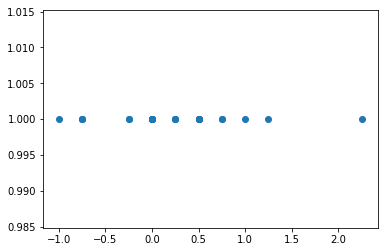

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


### 1.3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.13081582733992642
Testing Acc.: 0.9621000021696091
Epoch 2 completed, average training loss is 0.1262306270878374
Testing Acc.: 0.9555000001192093
Epoch 3 completed, average training loss is 0.12709251372764507
Testing Acc.: 0.9628000000119209
Epoch 4 completed, average training loss is 0.12472362627197678
Testing Acc.: 0.9554999989271163
Epoch 5 completed, average training loss is 0.12596301493855813
Testing Acc.: 0.9590999993681908
Epoch 6 completed, average training loss is 0.1239751492999494
Testing Acc.: 0.9587000000476837
Epoch 7 completed, average training loss is 0.12356240710321192
Testing Acc.: 0.9582000017166138
Epoch 8 completed, average training loss is 0.12107271721664195
Testing Acc.: 0.9594999995827674
Epoch 9 completed, average training loss is 0.12354366604510385
Testing Acc.: 0.9597999998927116
Epoch 10 completed, average training loss is 0.12199823176643501
Testing Acc.: 0.9611000022292138
Epoch 11 completed, average tra

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.9692000025510787


## 1.4 Extract conv weights

In [0]:
w1_values

In [0]:
sess.run(thresh)

In [0]:
with open('NP_WEIGHTS_1_layer_'+str(WIDTH)+'_kernels_bin_reg', 'wb') as f:
  pickle.dump(w1_values, f)

# 2 Manual loop for Independently trained networks, saved to gdrive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Width = 4

In [0]:
WIDTH = 4

### 1. Network definition

In [0]:
# Define the network
def net1(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv = slim.conv2d(input, WIDTH, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

### 2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 2.32869073788325
Testing Acc.: 0.7612999993562698
Epoch 2 completed, average training loss is 0.6133270651102066
Testing Acc.: 0.8492000007629394
Epoch 3 completed, average training loss is 0.4416038096944491
Testing Acc.: 0.8890000015497208
Epoch 4 completed, average training loss is 0.3469733088091016
Testing Acc.: 0.9142000031471252
Epoch 5 completed, average training loss is 0.2992813548197349
Testing Acc.: 0.9223000007867813
Epoch 6 completed, average training loss is 0.2724189790338278
Testing Acc.: 0.921900002360344
Epoch 7 completed, average training loss is 0.24393060408532619
Testing Acc.: 0.9348000037670136
Epoch 8 completed, average training loss is 0.22875529291729133
Testing Acc.: 0.9382000064849854
Epoch 9 completed, average training loss is 0.21547812417149545
Testing Acc.: 0.9410000038146973
Epoch 10 completed, average training loss is 0.2028738520729045
Testing Acc.: 0.9375000017881393
Epoch 11 completed, average training lo

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.97680000603199


0.97680000603199

In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

Testing Acc.: 0.97680000603199


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, '1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

'1_layer_4_kernels_bin_reg/model.ckpt'

In [0]:
!zip -r 1_layer_4_kernels_bin_reg.zip 1_layer_4_kernels_bin_reg

updating: 1_layer_4_kernels_bin_reg/ (stored 0%)
updating: 1_layer_4_kernels_bin_reg/model.ckpt.index (deflated 41%)
updating: 1_layer_4_kernels_bin_reg/checkpoint (deflated 42%)
updating: 1_layer_4_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 16%)
updating: 1_layer_4_kernels_bin_reg/model.ckpt.meta (deflated 88%)


In [0]:
!cp 1_layer_4_kernels_bin_reg.zip '/gdrive/My Drive/1_layer_4_kernels_bin_reg.zip'

### 3 Re-training FC after rounding the conv kernels

#### 3.1 Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9701000010967255

#### 3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9049999982118606


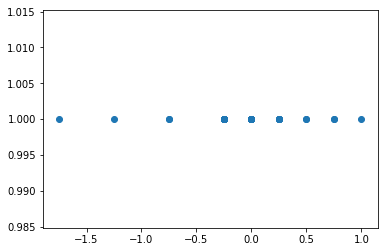

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### 3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.12310482204736521
Testing Acc.: 0.9562000009417534
Epoch 2 completed, average training loss is 0.12038828318395342
Testing Acc.: 0.9590000003576279
Epoch 3 completed, average training loss is 0.11819084783433936
Testing Acc.: 0.9641000020503998


KeyboardInterrupt: ignored

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.9760000020265579


In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## Width = 5

In [0]:
WIDTH = 5

### 1. Network definition

In [0]:
# Define the network
def net1(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv = slim.conv2d(input, WIDTH, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

### 2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 2.826973425646623
Testing Acc.: 0.7039999997615815
Epoch 2 completed, average training loss is 0.7872424451013406
Testing Acc.: 0.8169999998807908
Epoch 3 completed, average training loss is 0.5940998880565167
Testing Acc.: 0.8465999990701676
Epoch 4 completed, average training loss is 0.49298365709682307
Testing Acc.: 0.8776000022888184
Epoch 5 completed, average training loss is 0.4278121595581373
Testing Acc.: 0.8850000011920929
Epoch 6 completed, average training loss is 0.38540937083462873
Testing Acc.: 0.8651999992132187
Epoch 7 completed, average training loss is 0.3511374997223417
Testing Acc.: 0.9046000003814697
Epoch 8 completed, average training loss is 0.32199405793100594
Testing Acc.: 0.892600000500679
Epoch 9 completed, average training loss is 0.290653232584397
Testing Acc.: 0.924400001168251
Epoch 10 completed, average training loss is 0.2707856730371714
Testing Acc.: 0.916900002360344
Epoch 11 completed, average training loss

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9779000061750412


0.9779000061750412

In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

Testing Acc.: 0.9779000061750412


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, '1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

'1_layer_5_kernels_bin_reg/model.ckpt'

In [0]:
!zip -r 1_layer_5_kernels_bin_reg.zip 1_layer_5_kernels_bin_reg

updating: 1_layer_5_kernels_bin_reg/ (stored 0%)
updating: 1_layer_5_kernels_bin_reg/model.ckpt.index (deflated 41%)
updating: 1_layer_5_kernels_bin_reg/checkpoint (deflated 42%)
updating: 1_layer_5_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 35%)
updating: 1_layer_5_kernels_bin_reg/model.ckpt.meta (deflated 88%)


In [0]:
!cp 1_layer_5_kernels_bin_reg.zip '/gdrive/My Drive/1_layer_5_kernels_bin_reg.zip'

### 3 Re-training FC after rounding the conv kernels

#### 3.1 Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9700000011920928

#### 3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.5892000009864569


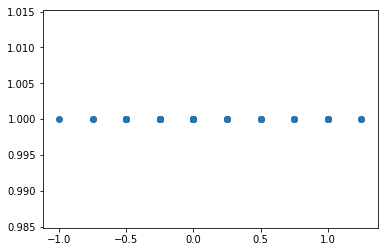

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### 3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.23282447618742783
Testing Acc.: 0.9583000013232231
Epoch 2 completed, average training loss is 0.1349996437931744
Testing Acc.: 0.9581999996304512
Epoch 3 completed, average training loss is 0.12132261975086295
Testing Acc.: 0.963600002527237
Epoch 4 completed, average training loss is 0.11477037478956238
Testing Acc.: 0.9630000001192093
Epoch 5 completed, average training loss is 0.1095889182765192
Testing Acc.: 0.9609999996423721
Epoch 6 completed, average training loss is 0.10548417939144808
Testing Acc.: 0.9662999993562699
Epoch 7 completed, average training loss is 0.10300819789272889
Testing Acc.: 0.9630000004172325
Epoch 8 completed, average training loss is 0.10144941152403286
Testing Acc.: 0.9662000000476837
Epoch 9 completed, average training loss is 0.09924832494260044
Testing Acc.: 0.963400000333786
Epoch 10 completed, average training loss is 0.09783306704950519
Testing Acc.: 0.9687000012397766
Epoch 11 completed, average train

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.9771000045537949


In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## Width = 6

In [0]:
WIDTH = 6

### 1. Network definition

In [0]:
# Define the network
def net1(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv = slim.conv2d(input, WIDTH, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

### 2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 3.1729555706183117
Testing Acc.: 0.7320999997854233
Epoch 2 completed, average training loss is 0.655610155214866
Testing Acc.: 0.840900001525879
Epoch 3 completed, average training loss is 0.4875565505276124
Testing Acc.: 0.8789999997615814
Epoch 4 completed, average training loss is 0.41102299066881337
Testing Acc.: 0.9055000013113021
Epoch 5 completed, average training loss is 0.3731092081094782
Testing Acc.: 0.8981000024080277
Epoch 6 completed, average training loss is 0.32242292371888953
Testing Acc.: 0.9136000019311905
Epoch 7 completed, average training loss is 0.2965290861700972
Testing Acc.: 0.9295000010728836
Epoch 8 completed, average training loss is 0.2836297700429956
Testing Acc.: 0.9132999986410141
Epoch 9 completed, average training loss is 0.2621237548813224
Testing Acc.: 0.9393000054359436
Epoch 10 completed, average training loss is 0.23910432505110898
Testing Acc.: 0.9303000038862228
Epoch 11 completed, average training l

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9801000064611435


0.9801000064611435

In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

Testing Acc.: 0.9801000064611435


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, '1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

'1_layer_6_kernels_bin_reg/model.ckpt'

In [0]:
!zip -r 1_layer_6_kernels_bin_reg.zip 1_layer_6_kernels_bin_reg

  adding: 1_layer_6_kernels_bin_reg/ (stored 0%)
  adding: 1_layer_6_kernels_bin_reg/model.ckpt.index (deflated 42%)
  adding: 1_layer_6_kernels_bin_reg/checkpoint (deflated 42%)
  adding: 1_layer_6_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 32%)
  adding: 1_layer_6_kernels_bin_reg/model.ckpt.meta (deflated 88%)


In [0]:
!cp 1_layer_6_kernels_bin_reg.zip '/gdrive/My Drive/1_layer_6_kernels_bin_reg.zip'

### 3 Re-training FC after rounding the conv kernels

#### 3.1 Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9801000028848648

#### 3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9801000028848648


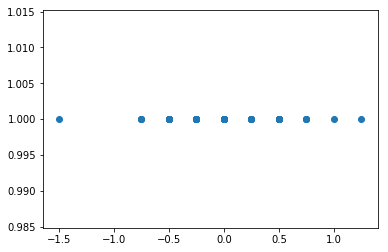

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### 3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.05736638384684435
Testing Acc.: 0.9759000024199486
Epoch 2 completed, average training loss is 0.05174668103538958
Testing Acc.: 0.9766000014543533
Epoch 3 completed, average training loss is 0.05504419326617305
Testing Acc.: 0.9759000039100647
Epoch 4 completed, average training loss is 0.05459063314513817
Testing Acc.: 0.9756000024080277
Epoch 5 completed, average training loss is 0.05613582097512942
Testing Acc.: 0.9766000032424926
Epoch 6 completed, average training loss is 0.05341616082499968
Testing Acc.: 0.9746000027656555
Epoch 7 completed, average training loss is 0.05384079397357709
Testing Acc.: 0.9781000006198883
Epoch 8 completed, average training loss is 0.05389846226678249
Testing Acc.: 0.9786000022292137
Epoch 9 completed, average training loss is 0.05375892330147811
Testing Acc.: 0.9698000001907349
Epoch 10 completed, average training loss is 0.05395674576900395
Testing Acc.: 0.9795000022649765
Epoch 11 completed, average t

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## Width = 7

In [0]:
WIDTH = 7

### 1. Network definition

In [0]:
# Define the network
def net1(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv = slim.conv2d(input, WIDTH, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

W0801 06:49:31.033485 140134320703360 deprecation.py:323] From <ipython-input-12-6b0af92fa759>:13: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0801 06:49:31.279275 140134320703360 deprecation.py:323] From <ipython-input-12-6b0af92fa759>:14: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0801 06:49:31.282169 140134320703360 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

### 2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 1.684840933829546
Testing Acc.: 0.8219000017642974
Epoch 2 completed, average training loss is 0.5437146830558777
Testing Acc.: 0.8684000003337861
Epoch 3 completed, average training loss is 0.4342179859181245
Testing Acc.: 0.8910000032186508
Epoch 4 completed, average training loss is 0.36935502911607426
Testing Acc.: 0.9124000042676925
Epoch 5 completed, average training loss is 0.3298118907958269
Testing Acc.: 0.9049000042676926
Epoch 6 completed, average training loss is 0.2954480288301905
Testing Acc.: 0.9187999987602233
Epoch 7 completed, average training loss is 0.2894072566429774
Testing Acc.: 0.9255000013113022
Epoch 8 completed, average training loss is 0.263130024249355
Testing Acc.: 0.9266000038385391
Epoch 9 completed, average training loss is 0.24162906184792518
Testing Acc.: 0.925700004696846
Epoch 10 completed, average training loss is 0.2265192652369539
Testing Acc.: 0.9370000046491623
Epoch 11 completed, average training los

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9785000050067901


0.9785000050067901

In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

Testing Acc.: 0.9785000050067901


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, '1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

'1_layer_7_kernels_bin_reg/model.ckpt'

In [0]:
!zip -r 1_layer_7_kernels_bin_reg.zip 1_layer_7_kernels_bin_reg

  adding: 1_layer_7_kernels_bin_reg/ (stored 0%)
  adding: 1_layer_7_kernels_bin_reg/model.ckpt.index (deflated 42%)
  adding: 1_layer_7_kernels_bin_reg/checkpoint (deflated 42%)
  adding: 1_layer_7_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 25%)
  adding: 1_layer_7_kernels_bin_reg/model.ckpt.meta (deflated 88%)


In [0]:
!cp 1_layer_7_kernels_bin_reg.zip '/gdrive/My Drive/1_layer_7_kernels_bin_reg.zip'

### 3 Re-training FC after rounding the conv kernels

#### 3.1 Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

W0801 07:26:31.055465 140134320703360 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.9785000026226044

#### 3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9785000026226044


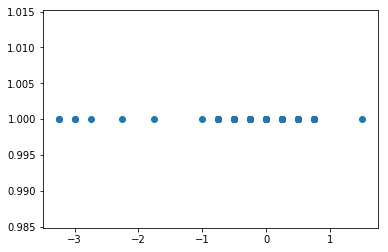

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### 3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.034076533897127774
Testing Acc.: 0.9781000030040741
Epoch 2 completed, average training loss is 0.03492067660175204
Testing Acc.: 0.9784000015258789
Epoch 3 completed, average training loss is 0.03380059331407514
Testing Acc.: 0.978500002026558
Epoch 4 completed, average training loss is 0.035647665121014145
Testing Acc.: 0.9764000025391578
Epoch 5 completed, average training loss is 0.034740821557879824
Testing Acc.: 0.9782000014185905
Epoch 6 completed, average training loss is 0.0354306804416107
Testing Acc.: 0.9781000033020973
Epoch 7 completed, average training loss is 0.033962843834371294
Testing Acc.: 0.9777000015974044
Epoch 8 completed, average training loss is 0.03458168508657157
Testing Acc.: 0.9752000004053116
Epoch 9 completed, average training loss is 0.035657881795292876
Testing Acc.: 0.9761000004410744
Epoch 10 completed, average training loss is 0.034333607827972325
Testing Acc.: 0.975800002515316
Epoch 11 completed, averag

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.9826000034809113


In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## Width = 8

In [0]:
WIDTH = 8

### 1. Network definition

In [0]:
# Define the network
def net1(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv = slim.conv2d(input, WIDTH, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

### 2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 2.4935917337735494
Testing Acc.: 0.7383000004291534
Epoch 2 completed, average training loss is 0.6693107864012321
Testing Acc.: 0.8441999971866607
Epoch 3 completed, average training loss is 0.4789355739702781
Testing Acc.: 0.8925
Epoch 4 completed, average training loss is 0.38639339175075293
Testing Acc.: 0.8983000010251999
Epoch 5 completed, average training loss is 0.33133086349194246
Testing Acc.: 0.9131000006198883
Epoch 6 completed, average training loss is 0.30243929258237284
Testing Acc.: 0.9219000047445297
Epoch 7 completed, average training loss is 0.25730916067957876
Testing Acc.: 0.920800005197525
Epoch 8 completed, average training loss is 0.2423227986941735
Testing Acc.: 0.9015999984741211
Epoch 9 completed, average training loss is 0.23514818352336686
Testing Acc.: 0.9453000032901764
Epoch 10 completed, average training loss is 0.21420873954271277
Testing Acc.: 0.9361000049114228
Epoch 11 completed, average training loss is 0

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9783000081777573


0.9783000081777573

In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

Testing Acc.: 0.9783000081777573


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, '1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

'1_layer_8_kernels_bin_reg/model.ckpt'

In [0]:
!zip -r 1_layer_8_kernels_bin_reg.zip 1_layer_8_kernels_bin_reg

  adding: 1_layer_8_kernels_bin_reg/ (stored 0%)
  adding: 1_layer_8_kernels_bin_reg/model.ckpt.meta (deflated 88%)
  adding: 1_layer_8_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 28%)
  adding: 1_layer_8_kernels_bin_reg/checkpoint (deflated 42%)
  adding: 1_layer_8_kernels_bin_reg/model.ckpt.index (deflated 42%)


In [0]:
!cp 1_layer_8_kernels_bin_reg.zip '/gdrive/My Drive/1_layer_8_kernels_bin_reg.zip'

### 3 Re-training FC after rounding the conv kernels

#### 3.1 Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

W0802 09:20:45.951642 140397818357632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.9783000028133393

#### 3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9783000028133393


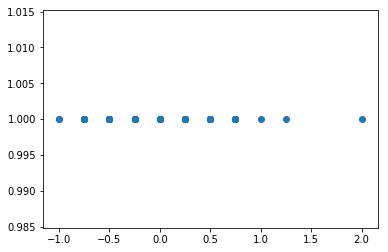

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### 3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.05810962068411754
Testing Acc.: 0.9746000012755394
Epoch 2 completed, average training loss is 0.058229334703016014
Testing Acc.: 0.9755000019073486
Epoch 3 completed, average training loss is 0.05678979796369579
Testing Acc.: 0.9759000039100647
Epoch 4 completed, average training loss is 0.05905607241676383
Testing Acc.: 0.9782000029087067
Epoch 5 completed, average training loss is 0.05513648298874614
Testing Acc.: 0.978200002014637
Epoch 6 completed, average training loss is 0.0567802730081894
Testing Acc.: 0.9773000028729438
Epoch 7 completed, average training loss is 0.05685537202070312
Testing Acc.: 0.9748000019788742
Epoch 8 completed, average training loss is 0.05680730959449041
Testing Acc.: 0.975600001513958
Epoch 9 completed, average training loss is 0.05429716619083289
Testing Acc.: 0.9764000037312508
Epoch 10 completed, average training loss is 0.055915563583742674
Testing Acc.: 0.9751000019907952
Epoch 11 completed, average tr

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## Width = 9

In [0]:
WIDTH = 9

### 1. Network definition

In [0]:
# Define the network
def net1(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv = slim.conv2d(input, WIDTH, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

W0802 13:19:59.000714 140507105253248 deprecation.py:323] From <ipython-input-12-6b0af92fa759>:13: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0802 13:19:59.355334 140507105253248 deprecation.py:323] From <ipython-input-12-6b0af92fa759>:14: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0802 13:19:59.358194 140507105253248 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

### 2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 2.489889164616664
Testing Acc.: 0.8167000007629395
Epoch 2 completed, average training loss is 0.5064985456814368
Testing Acc.: 0.8904000002145768
Epoch 3 completed, average training loss is 0.36181823782622813
Testing Acc.: 0.9091999983787536
Epoch 4 completed, average training loss is 0.3034209568053484
Testing Acc.: 0.9320000046491623
Epoch 5 completed, average training loss is 0.25400027512262263
Testing Acc.: 0.9241000044345856
Epoch 6 completed, average training loss is 0.23231978631267944
Testing Acc.: 0.9220000028610229
Epoch 7 completed, average training loss is 0.21710129090895255
Testing Acc.: 0.9342000043392181
Epoch 8 completed, average training loss is 0.20211406467482448
Testing Acc.: 0.935500002503395
Epoch 9 completed, average training loss is 0.1895511484891176
Testing Acc.: 0.9226000010967255
Epoch 10 completed, average training loss is 0.17033826807513833
Testing Acc.: 0.9290000015497207
Epoch 11 completed, average trainin

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.97960000872612


0.97960000872612

In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

Testing Acc.: 0.97960000872612


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, '1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

'1_layer_9_kernels_bin_reg/model.ckpt'

In [0]:
!zip -r 1_layer_9_kernels_bin_reg.zip 1_layer_9_kernels_bin_reg

  adding: 1_layer_9_kernels_bin_reg/ (stored 0%)
  adding: 1_layer_9_kernels_bin_reg/model.ckpt.meta (deflated 88%)
  adding: 1_layer_9_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 28%)
  adding: 1_layer_9_kernels_bin_reg/checkpoint (deflated 42%)
  adding: 1_layer_9_kernels_bin_reg/model.ckpt.index (deflated 42%)


In [0]:
!cp 1_layer_9_kernels_bin_reg.zip '/gdrive/My Drive/1_layer_9_kernels_bin_reg.zip'

In [0]:
!cp '/gdrive/My Drive/1_layer_9_kernels_bin_reg.zip' 1_layer_9_kernels_bin_reg.zip 

In [0]:
!unzip 1_layer_9_kernels_bin_reg.zip 

Archive:  1_layer_9_kernels_bin_reg.zip
   creating: 1_layer_9_kernels_bin_reg/
  inflating: 1_layer_9_kernels_bin_reg/model.ckpt.meta  
  inflating: 1_layer_9_kernels_bin_reg/model.ckpt.data-00000-of-00001  
  inflating: 1_layer_9_kernels_bin_reg/checkpoint  
  inflating: 1_layer_9_kernels_bin_reg/model.ckpt.index  


### 3 Re-training FC after rounding the conv kernels

#### 3.1 Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

W0802 13:20:41.274230 140507105253248 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.9796000018715858

#### 3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9796000018715858


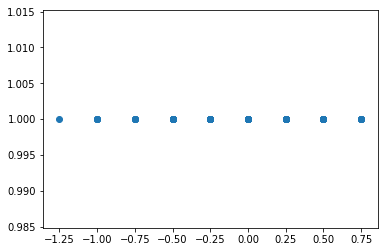

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### 3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.03724060318374351
Testing Acc.: 0.9723000001907348
Epoch 2 completed, average training loss is 0.03511039889333631
Testing Acc.: 0.9783000016212463
Epoch 3 completed, average training loss is 0.035797601779478945
Testing Acc.: 0.9756000033020973
Epoch 4 completed, average training loss is 0.03218779330137371
Testing Acc.: 0.9772000017762185
Epoch 5 completed, average training loss is 0.03560040011955456
Testing Acc.: 0.9769000005722046
Epoch 6 completed, average training loss is 0.03140569230557711
Testing Acc.: 0.9791000026464463
Epoch 7 completed, average training loss is 0.03711560940378073
Testing Acc.: 0.9794000002741814
Epoch 8 completed, average training loss is 0.033901550411138716
Testing Acc.: 0.9758000007271767
Epoch 9 completed, average training loss is 0.03486385009653986
Testing Acc.: 0.9802000007033348
Epoch 10 completed, average training loss is 0.03263748104747549
Testing Acc.: 0.9789999997615815
Epoch 11 completed, average

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.9818000018596649


In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## Width = 10

In [0]:
WIDTH = 10

### 1. Network definition

In [0]:
# Define the network
def net1(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv = slim.conv2d(input, WIDTH, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

### 2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, '1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

In [0]:
!zip -r 1_layer_10_kernels_bin_reg.zip 1_layer_10_kernels_bin_reg

In [0]:
!cp 1_layer_10_kernels_bin_reg.zip '/gdrive/My Drive/1_layer_10_kernels_bin_reg.zip'

### 3 Re-training FC after rounding the conv kernels

#### 3.1 Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

#### 3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### 3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

In [0]:
with open('/gdrive/My Drive/1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

# 3 Additively trained networks

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# Generic network definition
def conv_net(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv1 = slim.conv2d(input, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  conv2 = slim.conv2d(input, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv2')
  conv3 = slim.conv2d(input, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv3')
  conv4 = slim.conv2d(input, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv4')
  conv5 = slim.conv2d(input, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv5')
  conv6 = slim.conv2d(input, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv6')
  conv7 = slim.conv2d(input, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv7')
  conv8 = slim.conv2d(input, 1, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv8')
  
  conv = tf.concat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8], axis=-1)
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  return conv_bin
  

In [0]:
!cp '/gdrive/My Drive/additive_1_layer_1_kernels_bin_reg.zip' additive_1_layer_1_kernels_bin_reg.zip 

In [0]:
!unzip additive_1_layer_1_kernels_bin_reg.zip 

Archive:  additive_1_layer_1_kernels_bin_reg.zip
   creating: additive_1_layer_1_kernels_bin_reg/
  inflating: additive_1_layer_1_kernels_bin_reg/model.ckpt.meta  
  inflating: additive_1_layer_1_kernels_bin_reg/model.ckpt.data-00000-of-00001  
  inflating: additive_1_layer_1_kernels_bin_reg/checkpoint  
  inflating: additive_1_layer_1_kernels_bin_reg/model.ckpt.index  


## 3.1 1 kernel

In [0]:
WIDTH=1

### 3.1.1 Network definition

In [0]:
def net1(conv_bin):
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())


conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]

out_label_op = net1(conv_bin)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

W0802 20:54:21.102299 140358257174400 deprecation.py:323] From <ipython-input-14-cb66d05af89a>:6: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0802 20:54:21.328866 140358257174400 deprecation.py:323] From <ipython-input-14-cb66d05af89a>:7: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0802 20:54:21.331206 140358257174400 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')

with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op, var_list=[w1, b1, thresh,
                                                fc1_k, fc1_b,
                                                fc2_k, fc2_b])
sess.run(tf.variables_initializer(opt.variables()))

### 3.1.2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 3.074017958243688
Testing Acc.: 0.48519999474287034
Epoch 2 completed, average training loss is 1.2387093794345856
Testing Acc.: 0.6756000006198883
Epoch 3 completed, average training loss is 0.9259751084446907
Testing Acc.: 0.7200999993085861
Epoch 4 completed, average training loss is 0.8352626915772756
Testing Acc.: 0.7534999990463257
Epoch 5 completed, average training loss is 0.7972395173211893
Testing Acc.: 0.7587000042200088
Epoch 6 completed, average training loss is 0.7751306709150473
Testing Acc.: 0.7713999998569488
Epoch 7 completed, average training loss is 0.7225950619081656
Testing Acc.: 0.7804000014066697
Epoch 8 completed, average training loss is 0.683965354214112
Testing Acc.: 0.7933999961614608
Epoch 9 completed, average training loss is 0.6666074141363303
Testing Acc.: 0.7832000011205673
Epoch 10 completed, average training loss is 0.6559369001785914
Testing Acc.: 0.800699999332428
Epoch 11 completed, average training loss

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

NameError: ignored

In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

#### Round weights and save

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate(MAX_BIN_RATE)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, 'additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

In [0]:
!zip -r additive_1_layer_1_kernels_bin_reg.zip additive_1_layer_1_kernels_bin_reg

In [0]:
!cp additive_1_layer_1_kernels_bin_reg.zip '/gdrive/My Drive/additive_1_layer_1_kernels_bin_reg.zip'

### 3.1.3 Re-training FC after rounding the conv kernels

#### Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
out_label_op = net1(conv_bin)


pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

W0802 20:54:38.918020 140358257174400 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.8829999977350235

#### Round weights

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
sess.run(w1)

array([[[[-0.5 ]],

        [[ 0.  ]],

        [[ 0.25]]],


       [[[-0.25]],

        [[-4.25]],

        [[-1.  ]]],


       [[[ 0.5 ]],

        [[ 0.25]],

        [[-0.25]]]], dtype=float32)

Testing Acc.: 0.8829999977350235


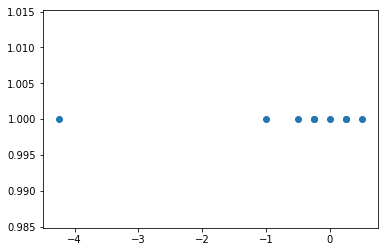

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.3632749476470053
Testing Acc.: 0.8792999950051308
Epoch 2 completed, average training loss is 0.36252188751474024
Testing Acc.: 0.8823999980092049
Epoch 3 completed, average training loss is 0.35928367196892697
Testing Acc.: 0.8767999938130379
Epoch 4 completed, average training loss is 0.35842878243575493
Testing Acc.: 0.878299997150898
Epoch 5 completed, average training loss is 0.3603733801841736
Testing Acc.: 0.8845999953150749
Epoch 6 completed, average training loss is 0.3589843575594326
Testing Acc.: 0.8707999956607818
Epoch 7 completed, average training loss is 0.35979502988358336
Testing Acc.: 0.8729999953508377
Epoch 8 completed, average training loss is 0.35841317381709814
Testing Acc.: 0.8800999960303306
Epoch 9 completed, average training loss is 0.35999845476821063
Testing Acc.: 0.8741999945044517
Epoch 10 completed, average training loss is 0.35768969828262925
Testing Acc.: 0.8825999939441681
Epoch 11 completed, average train

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.8952999949455261


In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## 3.2 2 kernels, re-using previous one

In [0]:
WIDTH = 2

### 3.2.1 Network definition

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

# Restore conv part
conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH-1)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)

In [0]:
out_label_op = net1(conv_bin)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Init un-initialized variables:
uninitialized_variables = set([n.decode('UTF-8') for n in
                            list(sess.run(tf.report_uninitialized_variables()))])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables
])
sess.run(init_op)

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')

with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op, var_list=[w1, b1, thresh,
                                                fc1_k, fc1_b,
                                                fc2_k, fc2_b])
sess.run(tf.variables_initializer(opt.variables()))

### 3.2.2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

#### Round weights and save

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate(MAX_BIN_RATE)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, 'additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

In [0]:
!zip -r additive_1_layer_2_kernels_bin_reg.zip additive_1_layer_2_kernels_bin_reg

In [0]:
!cp additive_1_layer_2_kernels_bin_reg.zip '/gdrive/My Drive/additive_1_layer_2_kernels_bin_reg.zip'

### 3.2.3 Re-training FC after rounding the conv kernels

#### Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
out_label_op = net1(conv_bin)


pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

#### Round weights

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## 3.3 3 kernels, re-using previous ones

In [0]:
WIDTH = 3

### 3.3.1 Network definition

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

# Restore conv part
conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH-1)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)

In [0]:
out_label_op = net1(conv_bin)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Init un-initialized variables:
uninitialized_variables = set([n.decode('UTF-8') for n in
                            list(sess.run(tf.report_uninitialized_variables()))])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables
])
sess.run(init_op)

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')

with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op, var_list=[w1, b1, thresh,
                                                fc1_k, fc1_b,
                                                fc2_k, fc2_b])
sess.run(tf.variables_initializer(opt.variables()))

### 3.3.2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

#### Round weights and save

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate(MAX_BIN_RATE)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, 'additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

In [0]:
!zip -r additive_1_layer_3_kernels_bin_reg.zip additive_1_layer_3_kernels_bin_reg

In [0]:
!cp additive_1_layer_3_kernels_bin_reg.zip '/gdrive/My Drive/additive_1_layer_3_kernels_bin_reg.zip'

### 3.3.3 Re-training FC after rounding the conv kernels

#### Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
out_label_op = net1(conv_bin)


pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

#### Round weights

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1bis = tf.get_variable('weights')
sess.run(w1bis)

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## 3.4 4 kernels, re-using previous ones

In [0]:
WIDTH = 4

### 3.4.1 Network definition

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

# Restore conv part
conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH-1)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)

In [0]:
out_label_op = net1(conv_bin)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Init un-initialized variables:
uninitialized_variables = set([n.decode('UTF-8') for n in
                            list(sess.run(tf.report_uninitialized_variables()))])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables
])
sess.run(init_op)

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')

with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op, var_list=[w1, b1, thresh,
                                                fc1_k, fc1_b,
                                                fc2_k, fc2_b])
sess.run(tf.variables_initializer(opt.variables()))

### 3.4.2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 2.501613853474458
Testing Acc.: 0.8235999977588654
Epoch 2 completed, average training loss is 0.4615094022949537
Testing Acc.: 0.8806999999284745
Epoch 3 completed, average training loss is 0.352093772093455
Testing Acc.: 0.903900004029274
Epoch 4 completed, average training loss is 0.30575034896532693
Testing Acc.: 0.9097000002861023
Epoch 5 completed, average training loss is 0.27540095244844753
Testing Acc.: 0.9172999995946884
Epoch 6 completed, average training loss is 0.255094721528391
Testing Acc.: 0.9262000006437302
Epoch 7 completed, average training loss is 0.23843193019429842
Testing Acc.: 0.9249000024795532
Epoch 8 completed, average training loss is 0.2256624597683549
Testing Acc.: 0.9341000026464462
Epoch 9 completed, average training loss is 0.21533135065808892
Testing Acc.: 0.9363000041246414
Epoch 10 completed, average training loss is 0.2075163226823012
Testing Acc.: 0.9381000053882599
Epoch 11 completed, average training lo

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9726000046730041


0.9726000046730041

In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

Testing Acc.: 0.9726000046730041


#### Round weights and save

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9726000046730041


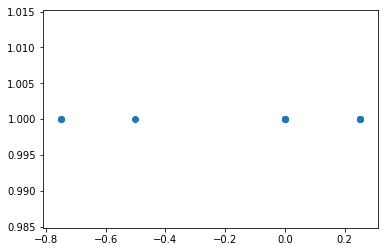

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate(MAX_BIN_RATE)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, 'additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

'additive_1_layer_4_kernels_bin_reg/model.ckpt'

In [0]:
!zip -r additive_1_layer_4_kernels_bin_reg.zip additive_1_layer_4_kernels_bin_reg

  adding: additive_1_layer_4_kernels_bin_reg/ (stored 0%)
  adding: additive_1_layer_4_kernels_bin_reg/model.ckpt.index (deflated 52%)
  adding: additive_1_layer_4_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 19%)
  adding: additive_1_layer_4_kernels_bin_reg/model.ckpt.meta (deflated 89%)
  adding: additive_1_layer_4_kernels_bin_reg/checkpoint (deflated 42%)


In [0]:
!cp additive_1_layer_4_kernels_bin_reg.zip '/gdrive/My Drive/additive_1_layer_4_kernels_bin_reg.zip'

### 3.4.3 Re-training FC after rounding the conv kernels

#### Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
out_label_op = net1(conv_bin)


pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9725999987125397

#### Round weights

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9725999987125397


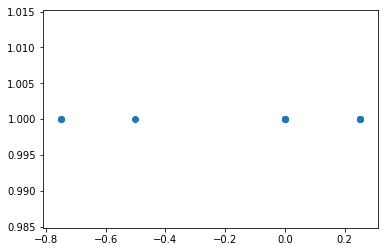

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.0540354811095555
Testing Acc.: 0.9674999997019768
Epoch 2 completed, average training loss is 0.05611495798123845
Testing Acc.: 0.9705000010132789
Epoch 3 completed, average training loss is 0.05507763551242533
Testing Acc.: 0.9704000008106232
Epoch 4 completed, average training loss is 0.0547239673817603
Testing Acc.: 0.9697999995946884
Epoch 5 completed, average training loss is 0.05464327235068291
Testing Acc.: 0.971800000667572
Epoch 6 completed, average training loss is 0.054749864090117624
Testing Acc.: 0.967700001001358
Epoch 7 completed, average training loss is 0.05393887495491072
Testing Acc.: 0.9703000009059906
Epoch 8 completed, average training loss is 0.05444835293368669
Testing Acc.: 0.9703000018000603
Epoch 9 completed, average training loss is 0.05335611844903421
Testing Acc.: 0.9700000011920928
Epoch 10 completed, average training loss is 0.05533029098109788
Testing Acc.: 0.9715000000596047
Epoch 11 completed, average trai

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.973900001347065


In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## 3.5 5 kernels, re-using previous ones

In [0]:
WIDTH = 5

### 3.5.1 Network definition

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

# Restore conv part
conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH-1)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)

In [0]:
out_label_op = net1(conv_bin)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Init un-initialized variables:
uninitialized_variables = set([n.decode('UTF-8') for n in
                            list(sess.run(tf.report_uninitialized_variables()))])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables
])
sess.run(init_op)

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')

with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op, var_list=[w1, b1, thresh,
                                                fc1_k, fc1_b,
                                                fc2_k, fc2_b])
sess.run(tf.variables_initializer(opt.variables()))

### 3.5.2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 1.190276893203457
Testing Acc.: 0.8990999972820282
Epoch 2 completed, average training loss is 0.2813474070529143
Testing Acc.: 0.9245000034570694
Epoch 3 completed, average training loss is 0.21857728672524293
Testing Acc.: 0.9366000026464463
Epoch 4 completed, average training loss is 0.18874560703833898
Testing Acc.: 0.9457000041007996
Epoch 5 completed, average training loss is 0.17551264234508077
Testing Acc.: 0.9457000017166137
Epoch 6 completed, average training loss is 0.16050971793631713
Testing Acc.: 0.9502000039815903
Epoch 7 completed, average training loss is 0.15185859221344192
Testing Acc.: 0.9555000025033951
Epoch 8 completed, average training loss is 0.14280149764070907
Testing Acc.: 0.9536000049114227
Epoch 9 completed, average training loss is 0.1400923252478242
Testing Acc.: 0.955400003194809
Epoch 10 completed, average training loss is 0.1347569435586532
Testing Acc.: 0.9577000039815903
Epoch 11 completed, average trainin

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9715000051259994


0.9715000051259994

In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

Testing Acc.: 0.9715000051259994


#### Round weights and save

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9715000051259994


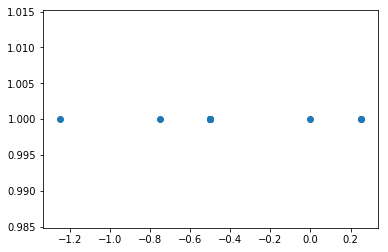

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate(MAX_BIN_RATE)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, 'additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

'additive_1_layer_5_kernels_bin_reg/model.ckpt'

In [0]:
!zip -r additive_1_layer_5_kernels_bin_reg.zip additive_1_layer_5_kernels_bin_reg

  adding: additive_1_layer_5_kernels_bin_reg/ (stored 0%)
  adding: additive_1_layer_5_kernels_bin_reg/model.ckpt.index (deflated 52%)
  adding: additive_1_layer_5_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 12%)
  adding: additive_1_layer_5_kernels_bin_reg/model.ckpt.meta (deflated 89%)
  adding: additive_1_layer_5_kernels_bin_reg/checkpoint (deflated 42%)


In [0]:
!cp additive_1_layer_5_kernels_bin_reg.zip '/gdrive/My Drive/additive_1_layer_5_kernels_bin_reg.zip'

### 3.5.3 Re-training FC after rounding the conv kernels

#### Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
out_label_op = net1(conv_bin)


pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9715000015497207

#### Round weights

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9715000015497207


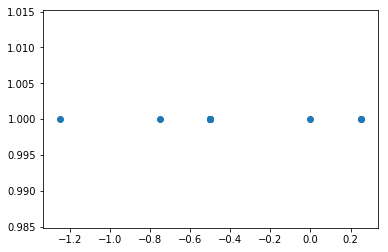

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.03924819125447054
Testing Acc.: 0.9702000012993812
Epoch 2 completed, average training loss is 0.040068795753234854
Testing Acc.: 0.9695000013709069
Epoch 3 completed, average training loss is 0.03972212599008344
Testing Acc.: 0.9706000006198883
Epoch 4 completed, average training loss is 0.0388772217945431
Testing Acc.: 0.9709000024199486
Epoch 5 completed, average training loss is 0.04069454565418407
Testing Acc.: 0.9721000012755394
Epoch 6 completed, average training loss is 0.039252023752742386
Testing Acc.: 0.9715000027418137
Epoch 7 completed, average training loss is 0.03892906142916217
Testing Acc.: 0.9721000024676323
Epoch 8 completed, average training loss is 0.03881462859842941
Testing Acc.: 0.9726000007987022
Epoch 9 completed, average training loss is 0.03927485044820363
Testing Acc.: 0.9725000011920929
Epoch 10 completed, average training loss is 0.040543517032498734
Testing Acc.: 0.9718000015616417
Epoch 11 completed, average

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.9742000016570092


In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## 3.6 6 kernels, re-using previous ones

In [0]:
WIDTH = 6

### 3.6.1 Network definition

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

# Restore conv part
conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH-1)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)

In [0]:
out_label_op = net1(conv_bin)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Init un-initialized variables:
uninitialized_variables = set([n.decode('UTF-8') for n in
                            list(sess.run(tf.report_uninitialized_variables()))])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables
])
sess.run(init_op)

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')

with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op, var_list=[w1, b1, thresh,
                                                fc1_k, fc1_b,
                                                fc2_k, fc2_b])
sess.run(tf.variables_initializer(opt.variables()))

### 3.6.2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 1.0265438719590505
Testing Acc.: 0.9105000013113022
Epoch 2 completed, average training loss is 0.24182658618936936
Testing Acc.: 0.9393000018596649
Epoch 3 completed, average training loss is 0.181025829911232
Testing Acc.: 0.9460000050067902
Epoch 4 completed, average training loss is 0.15795072571374477
Testing Acc.: 0.9481000024080276
Epoch 5 completed, average training loss is 0.1405824945649753
Testing Acc.: 0.957100003361702
Epoch 6 completed, average training loss is 0.1362295959641536
Testing Acc.: 0.9609000051021576
Epoch 7 completed, average training loss is 0.1253134698762248
Testing Acc.: 0.9605000048875809
Epoch 8 completed, average training loss is 0.12013560194522142
Testing Acc.: 0.9613000041246414
Epoch 9 completed, average training loss is 0.11541667781459788
Testing Acc.: 0.9596000069379806
Epoch 10 completed, average training loss is 0.11120724802215894
Testing Acc.: 0.9607000064849853
Epoch 11 completed, average training

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.9724000060558319


0.9724000060558319

In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

Testing Acc.: 0.9724000060558319


#### Round weights and save

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9724000060558319


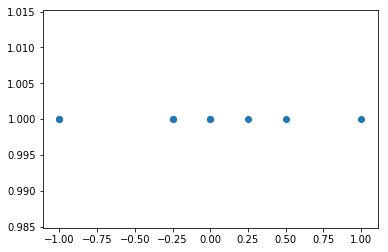

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate(MAX_BIN_RATE)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, 'additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

'additive_1_layer_6_kernels_bin_reg/model.ckpt'

In [0]:
!zip -r additive_1_layer_6_kernels_bin_reg.zip additive_1_layer_6_kernels_bin_reg

  adding: additive_1_layer_6_kernels_bin_reg/ (stored 0%)
  adding: additive_1_layer_6_kernels_bin_reg/model.ckpt.index (deflated 51%)
  adding: additive_1_layer_6_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 16%)
  adding: additive_1_layer_6_kernels_bin_reg/model.ckpt.meta (deflated 89%)
  adding: additive_1_layer_6_kernels_bin_reg/checkpoint (deflated 42%)


In [0]:
!cp additive_1_layer_6_kernels_bin_reg.zip '/gdrive/My Drive/additive_1_layer_6_kernels_bin_reg.zip'

### 3.6.3 Re-training FC after rounding the conv kernels

#### Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
out_label_op = net1(conv_bin)


pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9724000018835067

#### Round weights

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9724000018835067


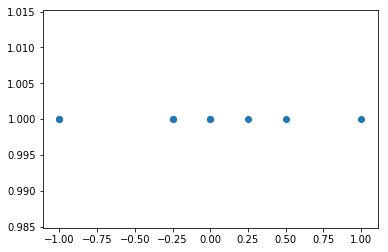

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.03413169255771208
Testing Acc.: 0.9711000007390976
Epoch 2 completed, average training loss is 0.03440968846393086
Testing Acc.: 0.9710000005364418
Epoch 3 completed, average training loss is 0.033289233780424185
Testing Acc.: 0.971200000345707
Epoch 4 completed, average training loss is 0.03427074800984845
Testing Acc.: 0.9708000010251999
Epoch 5 completed, average training loss is 0.0323083855548839
Testing Acc.: 0.9702999994158745
Epoch 6 completed, average training loss is 0.03445809634685247
Testing Acc.: 0.9711999997496605
Epoch 7 completed, average training loss is 0.03519639409733979
Testing Acc.: 0.9709999999403953
Epoch 8 completed, average training loss is 0.033116171993664616
Testing Acc.: 0.9714000022411347
Epoch 9 completed, average training loss is 0.034885176967726084
Testing Acc.: 0.9716000005602836
Epoch 10 completed, average training loss is 0.03294307595448269
Testing Acc.: 0.9732000011205674
Epoch 11 completed, average 

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## 3.7 7 kernels, re-using previous ones

In [0]:
WIDTH = 7

### 3.7.1 Network definition

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

# Restore conv part
conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH-1)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)

In [0]:
out_label_op = net1(conv_bin)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Init un-initialized variables:
uninitialized_variables = set([n.decode('UTF-8') for n in
                            list(sess.run(tf.report_uninitialized_variables()))])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables
])
sess.run(init_op)

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')

with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op, var_list=[w1, b1, thresh,
                                                fc1_k, fc1_b,
                                                fc2_k, fc2_b])
sess.run(tf.variables_initializer(opt.variables()))

### 3.7.2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

#### Round weights and save

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate(MAX_BIN_RATE)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, 'additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

In [0]:
!zip -r additive_1_layer_7_kernels_bin_reg.zip additive_1_layer_7_kernels_bin_reg

In [0]:
!cp additive_1_layer_7_kernels_bin_reg.zip '/gdrive/My Drive/additive_1_layer_7_kernels_bin_reg.zip'

### 3.7.3 Re-training FC after rounding the conv kernels

#### Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
out_label_op = net1(conv_bin)


pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9749000015854835

#### Round weights

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9749000015854835


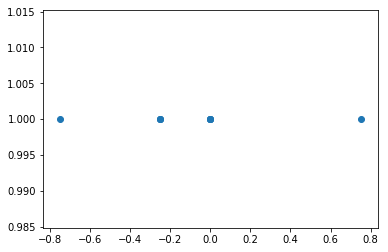

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.028986660025430357
Testing Acc.: 0.9743000027537346
Epoch 2 completed, average training loss is 0.02676910584486876
Testing Acc.: 0.9726000013947487
Epoch 3 completed, average training loss is 0.028642864547865278
Testing Acc.: 0.9732000014185905
Epoch 4 completed, average training loss is 0.026891344862872302
Testing Acc.: 0.9731000015139579
Epoch 5 completed, average training loss is 0.03124275271392624
Testing Acc.: 0.9715000003576278
Epoch 6 completed, average training loss is 0.02781458353219127
Testing Acc.: 0.9746000021696091
Epoch 7 completed, average training loss is 0.02664736393562502
Testing Acc.: 0.9733000010251999
Epoch 8 completed, average training loss is 0.029926454959331182
Testing Acc.: 0.9739000034332276
Epoch 9 completed, average training loss is 0.027662798470534444
Testing Acc.: 0.9751000013947487
Epoch 10 completed, average training loss is 0.027275509088846402
Testing Acc.: 0.9746000024676323
Epoch 11 completed, ave

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.9776000010967255


In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

## 3.8 8 kernels, re-using previous ones

In [0]:
WIDTH = 8

### 3.8.1 Network definition

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

# Restore conv part
conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH-1)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)

In [0]:
out_label_op = net1(conv_bin)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Init un-initialized variables:
uninitialized_variables = set([n.decode('UTF-8') for n in
                            list(sess.run(tf.report_uninitialized_variables()))])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables
])
sess.run(init_op)

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')

with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op, var_list=[w1, b1, thresh,
                                                fc1_k, fc1_b,
                                                fc2_k, fc2_b])
sess.run(tf.variables_initializer(opt.variables()))

### 3.8.2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_first_phase_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate(bin_rate_feed))
  f.write(acc)

#### Round weights and save

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate(MAX_BIN_RATE)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


In [0]:
# Save models, for not having to fully retrain it each time.
# Then zip it, and copy it to gdrive
saver = tf.train.Saver()
saver.save(sess, 'additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg/model.ckpt')

In [0]:
!zip -r additive_1_layer_8_kernels_bin_reg.zip additive_1_layer_8_kernels_bin_reg

In [0]:
!cp additive_1_layer_8_kernels_bin_reg.zip '/gdrive/My Drive/additive_1_layer_8_kernels_bin_reg.zip'

### 3.8.3 Re-training FC after rounding the conv kernels

#### Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([8]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

conv_bin = conv_net(in_image_ph, thresh, bin_rate_ph)[...,:WIDTH]
out_label_op = net1(conv_bin)


pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('additive_1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9773000013828278

0.9765999987721443

#### Round weights

In [0]:
with tf.variable_scope('conv'+str(WIDTH), reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9773000013828278


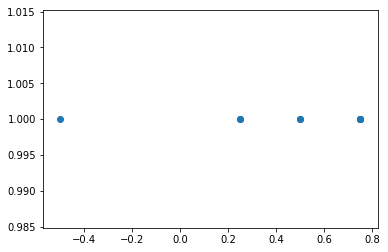

Testing Acc.: 0.9765999987721443


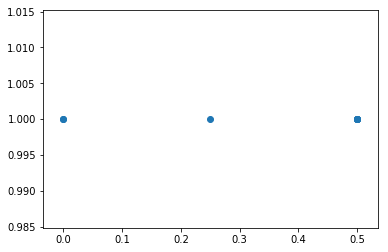

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


#### Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.03458429521981278
Testing Acc.: 0.975300001502037
Epoch 2 completed, average training loss is 0.03640191592862162
Testing Acc.: 0.9759000012278557
Epoch 3 completed, average training loss is 0.034637505903636644
Testing Acc.: 0.9762000021338463
Epoch 4 completed, average training loss is 0.03459348658885247
Testing Acc.: 0.9756000006198883
Epoch 5 completed, average training loss is 0.03323893525478752
Testing Acc.: 0.9762000015377998
Epoch 6 completed, average training loss is 0.03396085643913452
Testing Acc.: 0.9766000020503998
Epoch 7 completed, average training loss is 0.03340774344013785
Testing Acc.: 0.9764000001549721
Epoch 8 completed, average training loss is 0.03410083539841632
Testing Acc.: 0.9759000006318093
Epoch 9 completed, average training loss is 0.03651369569376432
Testing Acc.: 0.9766000005602836
Epoch 10 completed, average training loss is 0.031654440463347935
Testing Acc.: 0.9712000021338463
Epoch 11 completed, average 

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.9798000007867813


In [0]:
with open('/gdrive/My Drive/additive_1_layer_'+str(WIDTH)+'_kernels_final_accuracy.txt', 'w') as f:
  acc = str(test_accuracy_bin_rate_fc(bin_rate_feed))
  f.write(acc)

# 4 Extract weights

In [0]:
!unzip 1_layer_1_kernels_bin_reg.zip
!unzip 1_layer_2_kernels_bin_reg.zip
!unzip 1_layer_3_kernels_bin_reg.zip
#!unzip 1_layer_4_kernels_bin_reg.zip
#!unzip 1_layer_5_kernels_bin_reg.zip
!unzip 1_layer_6_kernels_bin_reg.zip
!unzip 1_layer_7_kernels_bin_reg.zip
!unzip 1_layer_8_kernels_bin_reg.zip

Archive:  1_layer_1_kernels_bin_reg.zip
   creating: 1_layer_1_kernels_bin_reg/
  inflating: 1_layer_1_kernels_bin_reg/model.ckpt.index  
  inflating: 1_layer_1_kernels_bin_reg/checkpoint  
  inflating: 1_layer_1_kernels_bin_reg/model.ckpt.data-00000-of-00001  
  inflating: 1_layer_1_kernels_bin_reg/model.ckpt.meta  
Archive:  1_layer_2_kernels_bin_reg.zip
   creating: 1_layer_2_kernels_bin_reg/
  inflating: 1_layer_2_kernels_bin_reg/model.ckpt.index  
  inflating: 1_layer_2_kernels_bin_reg/checkpoint  
  inflating: 1_layer_2_kernels_bin_reg/model.ckpt.data-00000-of-00001  
  inflating: 1_layer_2_kernels_bin_reg/model.ckpt.meta  
Archive:  1_layer_3_kernels_bin_reg.zip
   creating: 1_layer_3_kernels_bin_reg/
  inflating: 1_layer_3_kernels_bin_reg/model.ckpt.index  
  inflating: 1_layer_3_kernels_bin_reg/checkpoint  
  inflating: 1_layer_3_kernels_bin_reg/model.ckpt.data-00000-of-00001  
  inflating: 1_layer_3_kernels_bin_reg/model.ckpt.meta  
Archive:  1_layer_6_kernels_bin_reg.zip
   

In [0]:
!unzip 1_layer_4_kernels_bin_reg.zip
!unzip 1_layer_5_kernels_bin_reg.zip

Archive:  1_layer_4_kernels_bin_reg.zip
   creating: 1_layer_4_kernels_bin_reg/
  inflating: 1_layer_4_kernels_bin_reg/model.ckpt.index  
  inflating: 1_layer_4_kernels_bin_reg/checkpoint  
  inflating: 1_layer_4_kernels_bin_reg/model.ckpt.data-00000-of-00001  
  inflating: 1_layer_4_kernels_bin_reg/model.ckpt.meta  
Archive:  1_layer_5_kernels_bin_reg.zip
   creating: 1_layer_5_kernels_bin_reg/
  inflating: 1_layer_5_kernels_bin_reg/model.ckpt.index  
  inflating: 1_layer_5_kernels_bin_reg/checkpoint  
  inflating: 1_layer_5_kernels_bin_reg/model.ckpt.data-00000-of-00001  
  inflating: 1_layer_5_kernels_bin_reg/model.ckpt.meta  


In [0]:
WIDTH = 5

In [0]:
# Define the network
def net1(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv = slim.conv2d(input, WIDTH, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  pool = custom_pooling(conv_bin)
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,28,28,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('1_layer_'+str(WIDTH)+'_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9700000011920928

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

In [0]:
sess.run(w1)

Testing Acc.: 0.9264999976754189


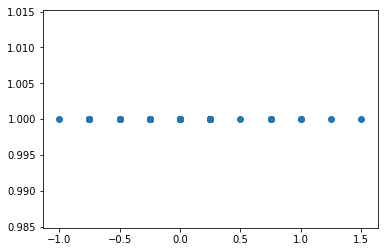

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


In [0]:
with open('NP_WEIGHTS_1_layer_'+str(WIDTH)+'_kernels.pck', 'wb') as f:
  pickle.dump(w1_values, f)